In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

def create_trigger(pattern=None, size=9):
    """
    创建一个size x size的trigger,由3x3的黑白方块交替组成
    
    参数:
    pattern : 一个长度为(size/3)^2的列表,指定每个3x3块的颜色(0为黑,1为白)
               如果不指定,则随机生成
    size : 触发器的大小，默认为9
    
    返回:
    trigger : size x size的PIL Image对象,黑白图案
    """
    block_num = (size // 3) ** 2
    if pattern is None:
        pattern = np.random.randint(0, 2, block_num)
    elif len(pattern) != block_num:
        raise ValueError(f"Pattern must be a list of length {block_num}")
    
    trigger = np.zeros((size, size), dtype=np.uint8)
    
    for i in range(size // 3):
        for j in range(size // 3):
            if pattern[i * (size // 3) + j] == 1:
                trigger[i*3:i*3+3, j*3:j*3+3] = 255
    
    return Image.fromarray(trigger)

class AddTrigger(object):
    def __init__(self, trigger_img):
        self.trigger = trigger_img

    def __call__(self, img):
        return self.add_trigger(img)

    def add_trigger(self, img):
        # 确保图像是PIL Image
        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)

        # 获取原图和触发器的尺寸
        img_width, img_height = img.size
        trigger_width, trigger_height = self.trigger.size

        # 计算触发器的位置（右下角）
        position = (img_width - trigger_width, img_height - trigger_height)

        # 创建一个新的图像，大小与原图相同
        new_img = img.copy()
        # 将触发器粘贴到新图像上
        new_img.paste(self.trigger, position)

        return new_img

# 创建一个特定模式的trigger
specific_pattern = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 棋盘模式
trigger_img = create_trigger(specific_pattern, size=9)


class ImagenetteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)} # class名字到class index的字典映射
        self.images = self._load_images()
        

    def _load_images(self):
        images = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label
    def random_select_delete_remain(self, proportion):
        # 从数据集中随即保留proportion比例的数据,
        import random
        random.shuffle(self.images)
        self.images = self.images[:int(len(self.images)*proportion)]
    def get_class_num(self):
        class_num = {}
        for _, label in self.images:
            if label not in class_num:
                class_num[label] = 1
            else:
                class_num[label] += 1
        return class_num

# 分离出ImageNetteDataset的一部分作为一个新的数据集
def split_dataset(dataset, proportion):
    n = len(dataset)
    split_idx = int(n * proportion)
    split_dataset = ImagenetteDataset(root_dir=dataset.root_dir, transform=dataset.transform)
    split_dataset.images = dataset.images[:split_idx]
    return split_dataset


# 定义预处理步骤
def get_transform(is_train=True):
    # ImageNet数据集的均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    if is_train:
        transform = transforms.Compose([
            transforms.Resize(256),  # 首先将图像调整为稍大的尺寸
            transforms.CenterCrop(224),  # 然后从中心裁剪出所需的224x224大小
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    return transform

# get_transform_trigger
def get_transform_add_trigger(is_train=True):
    # ImageNet数据集的均值和标准差
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    if is_train:
        transform = transforms.Compose([
            transforms.Resize(256),  # 首先将图像调整为稍大的尺寸
            transforms.CenterCrop(224),  # 然后从中心裁剪出所需的224x224大小
            AddTrigger(trigger_img),  # 使用特定的触发器模式
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    
    return transform

# 使用示例
train_transform = get_transform(is_train=True)
val_transform = get_transform(is_train=False)

# 假设您的Imagenette数据集路径
train_dataset = ImagenetteDataset(root_dir='/scratch/wenjie/imagenet12/train', transform=train_transform)
val_dataset = ImagenetteDataset(root_dir='/scratch/wenjie/imagenet12/eval', transform=val_transform)


train_dataset.random_select_delete_remain(0.1)
print(train_dataset.get_class_num())

{1: 103, 2: 112, 3: 92, 0: 126, 7: 121, 10: 115, 8: 101, 9: 83, 5: 96, 4: 104, 6: 106, 11: 89}


In [2]:
batch_size = 128
learning_rate = 0.1

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# 打印一个批次的形状和值范围
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Value range: [{images.min():.2f}, {images.max():.2f}]")
    break
print(len(train_loader))

Batch shape: torch.Size([128, 3, 224, 224])
Value range: [-2.12, 2.64]
10


In [1]:
# MobileNetV2, 用来训练ImageNet12数据集
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt


# 加载预训练的 MobileNetV2 模型
model = models.mobilenet_v2(pretrained=False)
# 修改最后的全连接层以输出 12 个类别
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 12)

/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [2]:
# 在gpu上训练
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import time
# CPU -> GPU
start = time.time()
model.to(device)
print(f"CPU -> GPU transfer time: {time.time() - start:.5f} seconds")

# GPU -> CPU
start = time.time()
model.to('cpu')
print(f"GPU -> CPU transfer time: {time.time() - start:.5f} seconds")

CPU -> GPU transfer time: 0.96001 seconds
GPU -> CPU transfer time: 0.00568 seconds


In [5]:
import torch.nn as nn
# 训练模型
num_epochs = 200

momentum = 0.9
weight_decay = 0
# weight_decay = 1e-4 # L2正则化系数

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    model.to(device)
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, train_loss))

    # 在测试集上评估模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}, Test Accuracy: {100 * correct / total}%")

Epoch: 0, Loss: 3.0529
Epoch 1, Test Accuracy: 8.333333333333334%
Epoch: 1, Loss: 3.8318
Epoch 2, Test Accuracy: 8.333333333333334%
Epoch: 2, Loss: 3.9782
Epoch 3, Test Accuracy: 8.333333333333334%
Epoch: 3, Loss: 3.3805
Epoch 4, Test Accuracy: 8.397435897435898%
Epoch: 4, Loss: 2.5526
Epoch 5, Test Accuracy: 10.48076923076923%
Epoch: 5, Loss: 2.3023
Epoch 6, Test Accuracy: 12.916666666666666%
Epoch: 6, Loss: 2.1453
Epoch 7, Test Accuracy: 25.32051282051282%
Epoch: 7, Loss: 2.1760
Epoch 8, Test Accuracy: 20.865384615384617%
Epoch: 8, Loss: 2.0295
Epoch 9, Test Accuracy: 22.98076923076923%
Epoch: 9, Loss: 1.8701
Epoch 10, Test Accuracy: 31.346153846153847%
Epoch: 10, Loss: 1.8729
Epoch 11, Test Accuracy: 31.41025641025641%
Epoch: 11, Loss: 1.7991
Epoch 12, Test Accuracy: 36.08974358974359%
Epoch: 12, Loss: 1.7752
Epoch 13, Test Accuracy: 30.92948717948718%
Epoch: 13, Loss: 1.7483
Epoch 14, Test Accuracy: 35.0%
Epoch: 14, Loss: 1.6620
Epoch 15, Test Accuracy: 41.794871794871796%
Epoch: 1

In [9]:
import torch
import numpy as np

def layer_wise_align_on_vector(vector, name_shapes_to_aggregate):
    start = 0
    for name, shape in name_shapes_to_aggregate.items():
        # 计算vector中对应位置的max
        max_value = torch.max(torch.abs(vector[start:start+np.prod(shape)]))
        # 计算vector中对应位置的sign
        sign = torch.sign(vector[start:start+np.prod(shape)])

        vector[start:start+np.prod(shape)] = sign * max_value
        start += np.prod(shape)
    return vector

# 例子
test_vector = torch.arange(1, 19).float()
test_vector[-2] = -10
# 模型的名字和形状
name_shapes = {}
name_shapes['a'] = (2, 3)
name_shapes['b'] = (3, 4)

# 对test_vector进行layer-wise的align
aligned_vector = layer_wise_align_on_vector(test_vector, name_shapes)
print(aligned_vector)

tensor([  6.,   6.,   6.,   6.,   6.,   6.,  18.,  18.,  18.,  18.,  18.,  18.,
         18.,  18.,  18.,  18., -18.,  18.])


In [ ]:
# # 10% 数据 128 0.1
# Epoch: 0, Loss: 3.0529
# Epoch 1, Test Accuracy: 8.333333333333334%
# Epoch: 1, Loss: 3.8318
# Epoch 2, Test Accuracy: 8.333333333333334%
# Epoch: 2, Loss: 3.9782
# Epoch 3, Test Accuracy: 8.333333333333334%
# Epoch: 3, Loss: 3.3805
# Epoch 4, Test Accuracy: 8.397435897435898%
# Epoch: 4, Loss: 2.5526
# Epoch 5, Test Accuracy: 10.48076923076923%
# Epoch: 5, Loss: 2.3023
# Epoch 6, Test Accuracy: 12.916666666666666%
# Epoch: 6, Loss: 2.1453
# Epoch 7, Test Accuracy: 25.32051282051282%
# Epoch: 7, Loss: 2.1760
# Epoch 8, Test Accuracy: 20.865384615384617%
# Epoch: 8, Loss: 2.0295
# Epoch 9, Test Accuracy: 22.98076923076923%
# Epoch: 9, Loss: 1.8701
# Epoch 10, Test Accuracy: 31.346153846153847%
# Epoch: 10, Loss: 1.8729
# Epoch 11, Test Accuracy: 31.41025641025641%
# Epoch: 11, Loss: 1.7991
# Epoch 12, Test Accuracy: 36.08974358974359%
# Epoch: 12, Loss: 1.7752
# Epoch 13, Test Accuracy: 30.92948717948718%
# Epoch: 13, Loss: 1.7483
# Epoch 14, Test Accuracy: 35.0%
# Epoch: 14, Loss: 1.6620
# Epoch 15, Test Accuracy: 41.794871794871796%
# Epoch: 15, Loss: 1.5857
# Epoch 16, Test Accuracy: 44.07051282051282%
# Epoch: 16, Loss: 1.4633
# Epoch 17, Test Accuracy: 46.02564102564103%
# Epoch: 17, Loss: 1.4129
# Epoch 18, Test Accuracy: 41.82692307692308%
# Epoch: 18, Loss: 1.3934
# Epoch 19, Test Accuracy: 46.6025641025641%
# Epoch: 19, Loss: 1.3523
# Epoch 20, Test Accuracy: 45.3525641025641%
# Epoch: 20, Loss: 1.3048
# Epoch 21, Test Accuracy: 47.21153846153846%
# Epoch: 21, Loss: 1.2084
# Epoch 22, Test Accuracy: 39.07051282051282%
# Epoch: 22, Loss: 1.2076
# Epoch 23, Test Accuracy: 34.743589743589745%
# Epoch: 23, Loss: 1.1118
# Epoch 24, Test Accuracy: 49.51923076923077%
# Epoch: 24, Loss: 1.0648
# Epoch 25, Test Accuracy: 40.16025641025641%
# Epoch: 25, Loss: 1.1133
# Epoch 26, Test Accuracy: 44.93589743589744%
# Epoch: 26, Loss: 1.0767
# Epoch 27, Test Accuracy: 49.67948717948718%
# Epoch: 27, Loss: 0.9822
# Epoch 28, Test Accuracy: 51.31410256410256%
# Epoch: 28, Loss: 0.8542
# Epoch 29, Test Accuracy: 48.26923076923077%
# Epoch: 29, Loss: 0.8770
# Epoch 30, Test Accuracy: 53.87820512820513%
# Epoch: 30, Loss: 0.8391
# Epoch 31, Test Accuracy: 44.35897435897436%
# Epoch: 31, Loss: 0.8143
# Epoch 32, Test Accuracy: 42.88461538461539%
# Epoch: 32, Loss: 0.7574
# Epoch 33, Test Accuracy: 52.37179487179487%
# Epoch: 33, Loss: 0.7259
# Epoch 34, Test Accuracy: 54.006410256410255%
# Epoch: 34, Loss: 0.6935
# Epoch 35, Test Accuracy: 53.55769230769231%
# Epoch: 35, Loss: 0.6063
# Epoch 36, Test Accuracy: 56.05769230769231%
# Epoch: 36, Loss: 0.5402
# Epoch 37, Test Accuracy: 47.94871794871795%
# Epoch: 37, Loss: 0.4863
# Epoch 38, Test Accuracy: 56.31410256410256%
# Epoch: 38, Loss: 0.5154
# Epoch 39, Test Accuracy: 55.92948717948718%
# Epoch: 39, Loss: 0.5323
# Epoch 40, Test Accuracy: 59.006410256410255%
# Epoch: 40, Loss: 0.5209
# Epoch 41, Test Accuracy: 53.493589743589745%
# Epoch: 41, Loss: 0.4414
# Epoch 42, Test Accuracy: 51.955128205128204%
# Epoch: 42, Loss: 0.3652
# Epoch 43, Test Accuracy: 50.51282051282051%
# Epoch: 43, Loss: 0.4011
# Epoch 44, Test Accuracy: 53.87820512820513%
# Epoch: 44, Loss: 0.3776
# Epoch 45, Test Accuracy: 57.5%
# Epoch: 45, Loss: 0.3565
# Epoch 46, Test Accuracy: 49.35897435897436%
# Epoch: 46, Loss: 0.3167
# Epoch 47, Test Accuracy: 50.64102564102564%
# Epoch: 47, Loss: 0.2817
# Epoch 48, Test Accuracy: 54.80769230769231%
# Epoch: 48, Loss: 0.3261
# Epoch 49, Test Accuracy: 58.97435897435897%
# Epoch: 49, Loss: 0.3076
# Epoch 50, Test Accuracy: 58.17307692307692%
# Epoch: 50, Loss: 0.2410
# Epoch 51, Test Accuracy: 56.08974358974359%
# Epoch: 51, Loss: 0.2031
# Epoch 52, Test Accuracy: 59.19871794871795%
# Epoch: 52, Loss: 0.2481
# Epoch 53, Test Accuracy: 56.53846153846154%
# Epoch: 53, Loss: 0.2053
# Epoch 54, Test Accuracy: 52.756410256410255%
# Epoch: 54, Loss: 0.2335
# Epoch 55, Test Accuracy: 55.0%
# Epoch: 55, Loss: 0.1873
# Epoch 56, Test Accuracy: 54.294871794871796%
# Epoch: 56, Loss: 0.1966
# Epoch 57, Test Accuracy: 53.42948717948718%
# Epoch: 57, Loss: 0.1938
# Epoch 58, Test Accuracy: 55.16025641025641%
# Epoch: 58, Loss: 0.1708
# Epoch 59, Test Accuracy: 57.11538461538461%
# Epoch: 59, Loss: 0.1617
# Epoch 60, Test Accuracy: 58.01282051282051%
# Epoch: 60, Loss: 0.1279
# Epoch 61, Test Accuracy: 55.64102564102564%
# Epoch: 61, Loss: 0.1364
# Epoch 62, Test Accuracy: 56.05769230769231%
# Epoch: 62, Loss: 0.1989
# Epoch 63, Test Accuracy: 56.666666666666664%
# Epoch: 63, Loss: 0.2430
# Epoch 64, Test Accuracy: 54.90384615384615%
# Epoch: 64, Loss: 0.1944
# Epoch 65, Test Accuracy: 55.64102564102564%
# Epoch: 65, Loss: 0.1556
# Epoch 66, Test Accuracy: 57.82051282051282%
# Epoch: 66, Loss: 0.1415
# Epoch 67, Test Accuracy: 61.57051282051282%
# Epoch: 67, Loss: 0.1128
# Epoch 68, Test Accuracy: 56.82692307692308%
# Epoch: 68, Loss: 0.1268
# Epoch 69, Test Accuracy: 57.27564102564103%
# Epoch: 69, Loss: 0.1312
# Epoch 70, Test Accuracy: 59.03846153846154%
# Epoch: 70, Loss: 0.1259
# Epoch 71, Test Accuracy: 55.60897435897436%
# Epoch: 71, Loss: 0.1524
# Epoch 72, Test Accuracy: 58.91025641025641%
# Epoch: 72, Loss: 0.0926
# Epoch 73, Test Accuracy: 62.11538461538461%
# Epoch: 73, Loss: 0.0717
# Epoch 74, Test Accuracy: 58.36538461538461%
# Epoch: 74, Loss: 0.0723
# Epoch 75, Test Accuracy: 56.506410256410255%
# Epoch: 75, Loss: 0.0709
# Epoch 76, Test Accuracy: 59.006410256410255%
# Epoch: 76, Loss: 0.0672
# Epoch 77, Test Accuracy: 59.19871794871795%
# Epoch: 77, Loss: 0.0736
# Epoch 78, Test Accuracy: 59.23076923076923%
# Epoch: 78, Loss: 0.0835
# Epoch 79, Test Accuracy: 61.92307692307692%
# Epoch: 79, Loss: 0.0900
# Epoch 80, Test Accuracy: 58.30128205128205%
# Epoch: 80, Loss: 0.1004
# Epoch 81, Test Accuracy: 59.51923076923077%
# Epoch: 81, Loss: 0.0902
# Epoch 82, Test Accuracy: 59.743589743589745%
# Epoch: 82, Loss: 0.0560
# Epoch 83, Test Accuracy: 61.955128205128204%
# Epoch: 83, Loss: 0.0556
# Epoch 84, Test Accuracy: 62.5%
# Epoch: 84, Loss: 0.0710
# Epoch 85, Test Accuracy: 61.69871794871795%
# Epoch: 85, Loss: 0.0549
# Epoch 86, Test Accuracy: 61.955128205128204%
# Epoch: 86, Loss: 0.0243
# Epoch 87, Test Accuracy: 62.30769230769231%
# Epoch: 87, Loss: 0.0270
# Epoch 88, Test Accuracy: 58.87820512820513%
# Epoch: 88, Loss: 0.0278
# Epoch 89, Test Accuracy: 57.40384615384615%
# Epoch: 89, Loss: 0.0299
# Epoch 90, Test Accuracy: 60.73717948717949%
# Epoch: 90, Loss: 0.0203
# Epoch 91, Test Accuracy: 62.33974358974359%
# Epoch: 91, Loss: 0.0170
# Epoch 92, Test Accuracy: 62.21153846153846%
# Epoch: 92, Loss: 0.0110
# Epoch 93, Test Accuracy: 64.48717948717949%
# Epoch: 93, Loss: 0.0120
# Epoch 94, Test Accuracy: 63.94230769230769%
# Epoch: 94, Loss: 0.0136
# Epoch 95, Test Accuracy: 62.94871794871795%
# Epoch: 95, Loss: 0.0154
# Epoch 96, Test Accuracy: 63.333333333333336%
# Epoch: 96, Loss: 0.0195
# Epoch 97, Test Accuracy: 61.73076923076923%
# Epoch: 97, Loss: 0.0213
# Epoch 98, Test Accuracy: 62.59615384615385%
# Epoch: 98, Loss: 0.0274
# Epoch 99, Test Accuracy: 62.37179487179487%
# Epoch: 99, Loss: 0.0304
# Epoch 100, Test Accuracy: 63.044871794871796%
# Epoch: 100, Loss: 0.0274
# Epoch 101, Test Accuracy: 59.42307692307692%
# Epoch: 101, Loss: 0.0344
# Epoch 102, Test Accuracy: 60.032051282051285%
# Epoch: 102, Loss: 0.0267
# Epoch 103, Test Accuracy: 62.37179487179487%
# Epoch: 103, Loss: 0.0230
# Epoch 104, Test Accuracy: 61.57051282051282%
# Epoch: 104, Loss: 0.0235
# Epoch 105, Test Accuracy: 62.30769230769231%
# Epoch: 105, Loss: 0.0150
# Epoch 106, Test Accuracy: 63.68589743589744%
# Epoch: 106, Loss: 0.0141
# Epoch 107, Test Accuracy: 63.84615384615385%
# Epoch: 107, Loss: 0.0138
# Epoch 108, Test Accuracy: 62.94871794871795%
# Epoch: 108, Loss: 0.0090
# Epoch 109, Test Accuracy: 62.88461538461539%
# Epoch: 109, Loss: 0.0117
# Epoch 110, Test Accuracy: 63.46153846153846%
# Epoch: 110, Loss: 0.0200
# Epoch 111, Test Accuracy: 62.82051282051282%
# Epoch: 111, Loss: 0.0121
# Epoch 112, Test Accuracy: 65.25641025641026%
# Epoch: 112, Loss: 0.0171
# Epoch 113, Test Accuracy: 62.756410256410255%
# Epoch: 113, Loss: 0.0154
# Epoch 114, Test Accuracy: 62.532051282051285%
# Epoch: 114, Loss: 0.0246
# Epoch 115, Test Accuracy: 60.8974358974359%
# Epoch: 115, Loss: 0.0152
# Epoch 116, Test Accuracy: 62.78846153846154%
# Epoch: 116, Loss: 0.0106
# Epoch 117, Test Accuracy: 64.55128205128206%
# Epoch: 117, Loss: 0.0140
# Epoch 118, Test Accuracy: 64.19871794871794%
# Epoch: 118, Loss: 0.0197
# Epoch 119, Test Accuracy: 62.82051282051282%
# Epoch: 119, Loss: 0.0126
# Epoch 120, Test Accuracy: 64.00641025641026%
# Epoch: 120, Loss: 0.0090
# Epoch 121, Test Accuracy: 64.03846153846153%
# Epoch: 121, Loss: 0.0090
# Epoch 122, Test Accuracy: 63.717948717948715%
# Epoch: 122, Loss: 0.0081
# Epoch 123, Test Accuracy: 64.16666666666667%
# Epoch: 123, Loss: 0.0099
# Epoch 124, Test Accuracy: 62.532051282051285%
# Epoch: 124, Loss: 0.0158
# Epoch 125, Test Accuracy: 61.73076923076923%
# Epoch: 125, Loss: 0.0222
# Epoch 126, Test Accuracy: 62.33974358974359%
# Epoch: 126, Loss: 0.0240
# Epoch 127, Test Accuracy: 62.17948717948718%
# Epoch: 127, Loss: 0.0254
# Epoch 128, Test Accuracy: 60.16025641025641%
# Epoch: 128, Loss: 0.0341
# Epoch 129, Test Accuracy: 61.282051282051285%
# Epoch: 129, Loss: 0.0351
# Epoch 130, Test Accuracy: 60.57692307692308%
# Epoch: 130, Loss: 0.0454
# Epoch 131, Test Accuracy: 59.583333333333336%
# Epoch: 131, Loss: 0.0537
# Epoch 132, Test Accuracy: 59.55128205128205%
# Epoch: 132, Loss: 0.0511
# Epoch 133, Test Accuracy: 61.63461538461539%
# Epoch: 133, Loss: 0.0400
# Epoch 134, Test Accuracy: 60.60897435897436%
# Epoch: 134, Loss: 0.0533
# Epoch 135, Test Accuracy: 60.28846153846154%
# Epoch: 135, Loss: 0.0740
# Epoch 136, Test Accuracy: 61.89102564102564%
# Epoch: 136, Loss: 0.0632
# Epoch 137, Test Accuracy: 61.31410256410256%
# Epoch: 137, Loss: 0.0553
# Epoch 138, Test Accuracy: 60.12820512820513%
# Epoch: 138, Loss: 0.0332
# Epoch 139, Test Accuracy: 61.05769230769231%
# Epoch: 139, Loss: 0.0397
# Epoch 140, Test Accuracy: 61.69871794871795%
# Epoch: 140, Loss: 0.0255
# Epoch 141, Test Accuracy: 61.217948717948715%
# Epoch: 141, Loss: 0.0390
# Epoch 142, Test Accuracy: 62.30769230769231%
# Epoch: 142, Loss: 0.0249
# Epoch 143, Test Accuracy: 62.69230769230769%
# Epoch: 143, Loss: 0.0240
# Epoch 144, Test Accuracy: 60.3525641025641%
# Epoch: 144, Loss: 0.0233
# Epoch 145, Test Accuracy: 61.282051282051285%
# Epoch: 145, Loss: 0.0228
# Epoch 146, Test Accuracy: 60.993589743589745%
# Epoch: 146, Loss: 0.0343
# Epoch 147, Test Accuracy: 61.25%
# Epoch: 147, Loss: 0.0169
# Epoch 148, Test Accuracy: 62.37179487179487%
# Epoch: 148, Loss: 0.0232
# Epoch 149, Test Accuracy: 61.217948717948715%
# Epoch: 149, Loss: 0.0242
# Epoch 150, Test Accuracy: 61.37820512820513%
# Epoch: 150, Loss: 0.0250
# Epoch 151, Test Accuracy: 60.64102564102564%
# Epoch: 151, Loss: 0.0212
# Epoch 152, Test Accuracy: 61.31410256410256%
# Epoch: 152, Loss: 0.0247
# Epoch 153, Test Accuracy: 61.282051282051285%
# Epoch: 153, Loss: 0.0132
# Epoch 154, Test Accuracy: 58.717948717948715%
# Epoch: 154, Loss: 0.0309
# Epoch 155, Test Accuracy: 61.92307692307692%
# Epoch: 155, Loss: 0.0136
# Epoch 156, Test Accuracy: 62.083333333333336%
# Epoch: 156, Loss: 0.0304
# Epoch 157, Test Accuracy: 62.532051282051285%
# Epoch: 157, Loss: 0.0242
# Epoch 158, Test Accuracy: 60.416666666666664%
# Epoch: 158, Loss: 0.0279
# Epoch 159, Test Accuracy: 62.33974358974359%
# Epoch: 159, Loss: 0.0197
# Epoch 160, Test Accuracy: 61.89102564102564%
# Epoch: 160, Loss: 0.0224
# Epoch 161, Test Accuracy: 62.37179487179487%
# Epoch: 161, Loss: 0.0211
# Epoch 162, Test Accuracy: 62.66025641025641%
# Epoch: 162, Loss: 0.0312
# Epoch 163, Test Accuracy: 61.44230769230769%
# Epoch: 163, Loss: 0.0355
# Epoch 164, Test Accuracy: 60.92948717948718%
# Epoch: 164, Loss: 0.0296
# Epoch 165, Test Accuracy: 61.53846153846154%
# Epoch: 165, Loss: 0.0234
# Epoch 166, Test Accuracy: 63.52564102564103%
# Epoch: 166, Loss: 0.0139
# Epoch 167, Test Accuracy: 64.2948717948718%
# Epoch: 167, Loss: 0.0130
# Epoch 168, Test Accuracy: 63.58974358974359%
# Epoch: 168, Loss: 0.0255
# Epoch 169, Test Accuracy: 62.59615384615385%
# Epoch: 169, Loss: 0.0165
# Epoch 170, Test Accuracy: 62.083333333333336%
# Epoch: 170, Loss: 0.0195
# Epoch 171, Test Accuracy: 61.53846153846154%
# Epoch: 171, Loss: 0.0128
# Epoch 172, Test Accuracy: 60.96153846153846%
# Epoch: 172, Loss: 0.0099
# Epoch 173, Test Accuracy: 63.42948717948718%
# Epoch: 173, Loss: 0.0042
# Epoch 174, Test Accuracy: 64.07051282051282%
# Epoch: 174, Loss: 0.0118
# Epoch 175, Test Accuracy: 65.8974358974359%
# Epoch: 175, Loss: 0.0040
# Epoch 176, Test Accuracy: 64.8076923076923%
# Epoch: 176, Loss: 0.0125
# Epoch 177, Test Accuracy: 64.32692307692308%
# Epoch: 177, Loss: 0.0124
# Epoch 178, Test Accuracy: 62.94871794871795%
# Epoch: 178, Loss: 0.0105
# Epoch 179, Test Accuracy: 63.782051282051285%
# Epoch: 179, Loss: 0.0116
# Epoch 180, Test Accuracy: 61.41025641025641%
# Epoch: 180, Loss: 0.0068
# Epoch 181, Test Accuracy: 63.333333333333336%
# Epoch: 181, Loss: 0.0073
# Epoch 182, Test Accuracy: 64.42307692307692%
# Epoch: 182, Loss: 0.0116
# Epoch 183, Test Accuracy: 64.6474358974359%
# Epoch: 183, Loss: 0.0049
# Epoch 184, Test Accuracy: 64.13461538461539%
# Epoch: 184, Loss: 0.0029
# Epoch 185, Test Accuracy: 64.4551282051282%
# Epoch: 185, Loss: 0.0016
# Epoch 186, Test Accuracy: 64.39102564102564%
# Epoch: 186, Loss: 0.0013
# Epoch 187, Test Accuracy: 65.0%
# Epoch: 187, Loss: 0.0035
# Epoch 188, Test Accuracy: 65.38461538461539%
# Epoch: 188, Loss: 0.0021
# Epoch 189, Test Accuracy: 64.87179487179488%
# Epoch: 189, Loss: 0.0033
# Epoch 190, Test Accuracy: 63.493589743589745%
# Epoch: 190, Loss: 0.0037
# Epoch 191, Test Accuracy: 64.13461538461539%
# Epoch: 191, Loss: 0.0028
# Epoch 192, Test Accuracy: 64.03846153846153%
# Epoch: 192, Loss: 0.0035
# Epoch 193, Test Accuracy: 64.13461538461539%
# Epoch: 193, Loss: 0.0052
# Epoch 194, Test Accuracy: 63.94230769230769%
# Epoch: 194, Loss: 0.0015
# Epoch 195, Test Accuracy: 63.23717948717949%
# Epoch: 195, Loss: 0.0054
# Epoch 196, Test Accuracy: 64.07051282051282%
# Epoch: 196, Loss: 0.0052
# Epoch 197, Test Accuracy: 63.46153846153846%
# Epoch: 197, Loss: 0.0013
# Epoch 198, Test Accuracy: 63.68589743589744%
# Epoch: 198, Loss: 0.0036
# Epoch 199, Test Accuracy: 63.10897435897436%
# Epoch: 199, Loss: 0.0022
# Epoch 200, Test Accuracy: 62.756410256410255%

In [6]:
# batch_size = 64
# learning_rate = 0.01

# Epoch: 0, Loss: 2.4985
# Epoch 1, Test Accuracy: 8.333333333333334%
# Epoch: 1, Loss: 2.3034
# Epoch 2, Test Accuracy: 11.057692307692308%
# Epoch: 2, Loss: 2.1631
# Epoch 3, Test Accuracy: 31.314102564102566%
# Epoch: 3, Loss: 2.0737
# Epoch 4, Test Accuracy: 29.455128205128204%
# Epoch: 4, Loss: 2.0066
# Epoch 5, Test Accuracy: 27.78846153846154%
# Epoch: 5, Loss: 1.9515
# Epoch 6, Test Accuracy: 39.93589743589744%
# Epoch: 6, Loss: 1.8830
# Epoch 7, Test Accuracy: 46.34615384615385%
# Epoch: 7, Loss: 1.8078
# Epoch 8, Test Accuracy: 36.98717948717949%
# Epoch: 8, Loss: 1.7677
# Epoch 9, Test Accuracy: 50.67307692307692%
# Epoch: 9, Loss: 1.6901
# Epoch 10, Test Accuracy: 53.84615384615385%
# Epoch: 10, Loss: 1.7320
# Epoch 11, Test Accuracy: 50.0%
# Epoch: 11, Loss: 1.6341
# Epoch 12, Test Accuracy: 47.756410256410255%
# Epoch: 12, Loss: 1.5898
# Epoch 13, Test Accuracy: 57.17948717948718%
# Epoch: 13, Loss: 1.5128
# Epoch 14, Test Accuracy: 56.794871794871796%
# Epoch: 14, Loss: 1.5693
# Epoch 15, Test Accuracy: 57.94871794871795%
# Epoch: 15, Loss: 1.4820
# Epoch 16, Test Accuracy: 56.25%
# Epoch: 16, Loss: 1.5141
# Epoch 17, Test Accuracy: 60.28846153846154%
# Epoch: 17, Loss: 1.4022
# Epoch 18, Test Accuracy: 63.044871794871796%
# Epoch: 18, Loss: 1.3857
# Epoch 19, Test Accuracy: 62.243589743589745%
# Epoch: 19, Loss: 1.3872
# Epoch 20, Test Accuracy: 53.55769230769231%
# Epoch: 20, Loss: 1.3657
# Epoch 21, Test Accuracy: 58.044871794871796%
# Epoch: 21, Loss: 1.2764
# Epoch 22, Test Accuracy: 63.333333333333336%
# Epoch: 22, Loss: 1.2844
# Epoch 23, Test Accuracy: 64.1025641025641%
# Epoch: 23, Loss: 1.2522
# Epoch 24, Test Accuracy: 57.11538461538461%
# Epoch: 24, Loss: 1.2526
# Epoch 25, Test Accuracy: 63.493589743589745%
# Epoch: 25, Loss: 1.2085
# Epoch 26, Test Accuracy: 63.493589743589745%
# Epoch: 26, Loss: 1.1821
# Epoch 27, Test Accuracy: 61.25%
# Epoch: 27, Loss: 1.1951
# Epoch 28, Test Accuracy: 66.41025641025641%
# Epoch: 28, Loss: 1.2076
# Epoch 29, Test Accuracy: 63.044871794871796%
# Epoch: 29, Loss: 1.2077
# Epoch 30, Test Accuracy: 69.48717948717949%
# Epoch: 30, Loss: 1.1012
# Epoch 31, Test Accuracy: 73.71794871794872%
# Epoch: 31, Loss: 1.1106
# Epoch 32, Test Accuracy: 68.26923076923077%
# Epoch: 32, Loss: 1.1134
# Epoch 33, Test Accuracy: 69.42307692307692%
# Epoch: 33, Loss: 1.0812
# Epoch 34, Test Accuracy: 70.67307692307692%
# Epoch: 34, Loss: 1.0660
# Epoch 35, Test Accuracy: 74.35897435897436%
# Epoch: 35, Loss: 0.9865
# Epoch 36, Test Accuracy: 70.8974358974359%
# Epoch: 36, Loss: 1.0079
# Epoch 37, Test Accuracy: 72.43589743589743%
# Epoch: 37, Loss: 0.9843
# Epoch 38, Test Accuracy: 73.07692307692308%
# Epoch: 38, Loss: 1.0135
# Epoch 39, Test Accuracy: 69.16666666666667%
# Epoch: 39, Loss: 1.0083
# Epoch 40, Test Accuracy: 70.5448717948718%
# Epoch: 40, Loss: 0.9708
# Epoch 41, Test Accuracy: 71.28205128205128%
# Epoch: 41, Loss: 0.9636
# Epoch 42, Test Accuracy: 75.32051282051282%
# Epoch: 42, Loss: 0.9646
# Epoch 43, Test Accuracy: 73.87820512820512%
# Epoch: 43, Loss: 0.9130
# Epoch 44, Test Accuracy: 72.88461538461539%
# Epoch: 44, Loss: 0.9650
# Epoch 45, Test Accuracy: 71.7948717948718%
# Epoch: 45, Loss: 0.9225
# Epoch 46, Test Accuracy: 75.60897435897436%
# Epoch: 46, Loss: 0.8877
# Epoch 47, Test Accuracy: 75.3525641025641%
# Epoch: 47, Loss: 0.8408
# Epoch 48, Test Accuracy: 78.01282051282051%
# Epoch: 48, Loss: 0.8472
# Epoch 49, Test Accuracy: 71.98717948717949%
# Epoch: 49, Loss: 0.8562
# Epoch 50, Test Accuracy: 78.49358974358974%
# Epoch: 50, Loss: 0.8462
# Epoch 51, Test Accuracy: 77.21153846153847%
# Epoch: 51, Loss: 0.8557
# Epoch 52, Test Accuracy: 77.75641025641026%
# Epoch: 52, Loss: 0.8065
# Epoch 53, Test Accuracy: 75.03205128205128%
# Epoch: 53, Loss: 0.7960
# Epoch 54, Test Accuracy: 75.8974358974359%
# Epoch: 54, Loss: 0.7944
# Epoch 55, Test Accuracy: 75.86538461538461%
# Epoch: 55, Loss: 0.7827
# Epoch 56, Test Accuracy: 78.65384615384616%
# Epoch: 56, Loss: 0.7448
# Epoch 57, Test Accuracy: 77.40384615384616%
# Epoch: 57, Loss: 0.7287
# Epoch 58, Test Accuracy: 77.08333333333333%
# Epoch: 58, Loss: 0.7436
# Epoch 59, Test Accuracy: 79.26282051282051%
# Epoch: 59, Loss: 0.7560
# Epoch 60, Test Accuracy: 78.68589743589743%
# Epoch: 60, Loss: 0.7371
# Epoch 61, Test Accuracy: 79.1025641025641%
# Epoch: 61, Loss: 0.7178
# Epoch 62, Test Accuracy: 74.23076923076923%
# Epoch: 62, Loss: 0.7227
# Epoch 63, Test Accuracy: 75.41666666666667%
# Epoch: 63, Loss: 0.7139
# Epoch 64, Test Accuracy: 77.56410256410257%
# Epoch: 64, Loss: 0.6641
# Epoch 65, Test Accuracy: 78.91025641025641%
# Epoch: 65, Loss: 0.7381
# Epoch 66, Test Accuracy: 78.97435897435898%
# Epoch: 66, Loss: 0.7037
# Epoch 67, Test Accuracy: 77.94871794871794%
# Epoch: 67, Loss: 0.7340
# Epoch 68, Test Accuracy: 80.41666666666667%
# Epoch: 68, Loss: 0.6814
# Epoch 69, Test Accuracy: 79.32692307692308%
# Epoch: 69, Loss: 0.6779
# Epoch 70, Test Accuracy: 77.75641025641026%
# Epoch: 70, Loss: 0.7095
# Epoch 71, Test Accuracy: 79.13461538461539%
# Epoch: 71, Loss: 0.6770
# Epoch 72, Test Accuracy: 81.37820512820512%
# Epoch: 72, Loss: 0.6236
# Epoch 73, Test Accuracy: 80.67307692307692%
# Epoch: 73, Loss: 0.6828
# Epoch 74, Test Accuracy: 79.35897435897436%
# Epoch: 74, Loss: 0.6693
# Epoch 75, Test Accuracy: 81.47435897435898%
# Epoch: 75, Loss: 0.6482
# Epoch 76, Test Accuracy: 80.28846153846153%
# Epoch: 76, Loss: 0.6355
# Epoch 77, Test Accuracy: 79.4551282051282%
# Epoch: 77, Loss: 0.5955
# Epoch 78, Test Accuracy: 77.78846153846153%
# Epoch: 78, Loss: 0.6345
# Epoch 79, Test Accuracy: 79.87179487179488%
# Epoch: 79, Loss: 0.5998
# Epoch 80, Test Accuracy: 81.50641025641026%
# Epoch: 80, Loss: 0.6197
# Epoch 81, Test Accuracy: 78.10897435897436%
# Epoch: 81, Loss: 0.6660
# Epoch 82, Test Accuracy: 80.57692307692308%
# Epoch: 82, Loss: 0.6022
# Epoch 83, Test Accuracy: 81.02564102564102%
# Epoch: 83, Loss: 0.5661
# Epoch 84, Test Accuracy: 81.53846153846153%
# Epoch: 84, Loss: 0.6097
# Epoch 85, Test Accuracy: 80.32051282051282%
# Epoch: 85, Loss: 0.5433
# Epoch 86, Test Accuracy: 80.22435897435898%
# Epoch: 86, Loss: 0.5903
# Epoch 87, Test Accuracy: 80.83333333333333%
# Epoch: 87, Loss: 0.5349
# Epoch 88, Test Accuracy: 78.33333333333333%
# Epoch: 88, Loss: 0.5690
# Epoch 89, Test Accuracy: 81.25%
# Epoch: 89, Loss: 0.5840
# Epoch 90, Test Accuracy: 81.15384615384616%
# Epoch: 90, Loss: 0.5646
# Epoch 91, Test Accuracy: 77.98076923076923%
# Epoch: 91, Loss: 0.5718
# Epoch 92, Test Accuracy: 80.25641025641026%
# Epoch: 92, Loss: 0.5077
# Epoch 93, Test Accuracy: 83.01282051282051%
# Epoch: 93, Loss: 0.6019
# Epoch 94, Test Accuracy: 80.41666666666667%
# Epoch: 94, Loss: 0.5507
# Epoch 95, Test Accuracy: 82.56410256410257%
# Epoch: 95, Loss: 0.5371
# Epoch 96, Test Accuracy: 80.80128205128206%
# Epoch: 96, Loss: 0.4970
# Epoch 97, Test Accuracy: 83.65384615384616%
# Epoch: 97, Loss: 0.5228
# Epoch 98, Test Accuracy: 81.02564102564102%
# Epoch: 98, Loss: 0.5231
# Epoch 99, Test Accuracy: 82.27564102564102%
# Epoch: 99, Loss: 0.4864
# Epoch 100, Test Accuracy: 82.46794871794872%
# Epoch: 100, Loss: 0.5336
# Epoch 101, Test Accuracy: 80.7051282051282%
# Epoch: 101, Loss: 0.4877
# Epoch 102, Test Accuracy: 83.10897435897436%
# Epoch: 102, Loss: 0.5088
# Epoch 103, Test Accuracy: 82.08333333333333%
# Epoch: 103, Loss: 0.4782
# Epoch 104, Test Accuracy: 80.5448717948718%
# Epoch: 104, Loss: 0.5261
# Epoch 105, Test Accuracy: 83.0448717948718%
# Epoch: 105, Loss: 0.4864
# Epoch 106, Test Accuracy: 81.9551282051282%
# Epoch: 106, Loss: 0.4866
# Epoch 107, Test Accuracy: 79.67948717948718%
# Epoch: 107, Loss: 0.5101
# Epoch 108, Test Accuracy: 80.80128205128206%
# Epoch: 108, Loss: 0.4859
# Epoch 109, Test Accuracy: 82.75641025641026%
# Epoch: 109, Loss: 0.5170
# Epoch 110, Test Accuracy: 80.28846153846153%
# Epoch: 110, Loss: 0.4696
# Epoch 111, Test Accuracy: 83.5576923076923%
# Epoch: 111, Loss: 0.4932
# Epoch 112, Test Accuracy: 83.81410256410257%
# Epoch: 112, Loss: 0.4546
# Epoch 113, Test Accuracy: 83.65384615384616%
# Epoch: 113, Loss: 0.4290
# Epoch 114, Test Accuracy: 82.33974358974359%
# Epoch: 114, Loss: 0.4392
# Epoch 115, Test Accuracy: 83.62179487179488%
# Epoch: 115, Loss: 0.4555
# Epoch 116, Test Accuracy: 82.05128205128206%
# Epoch: 116, Loss: 0.4202
# Epoch 117, Test Accuracy: 83.71794871794872%
# Epoch: 117, Loss: 0.4276
# Epoch 118, Test Accuracy: 81.57051282051282%
# Epoch: 118, Loss: 0.4361
# Epoch 119, Test Accuracy: 82.8525641025641%
# Epoch: 119, Loss: 0.4224
# Epoch 120, Test Accuracy: 83.33333333333333%
# Epoch: 120, Loss: 0.4673
# Epoch 121, Test Accuracy: 81.66666666666667%
# Epoch: 121, Loss: 0.4467
# Epoch 122, Test Accuracy: 82.88461538461539%
# Epoch: 122, Loss: 0.4532
# Epoch 123, Test Accuracy: 82.56410256410257%
# Epoch: 123, Loss: 0.4426
# Epoch 124, Test Accuracy: 83.81410256410257%
# Epoch: 124, Loss: 0.4284
# Epoch 125, Test Accuracy: 81.76282051282051%
# Epoch: 125, Loss: 0.4358
# Epoch 126, Test Accuracy: 83.75%
# Epoch: 126, Loss: 0.4264
# Epoch 127, Test Accuracy: 81.02564102564102%
# Epoch: 127, Loss: 0.4337
# Epoch 128, Test Accuracy: 83.26923076923077%
# Epoch: 128, Loss: 0.4178
# Epoch 129, Test Accuracy: 82.5%
# Epoch: 129, Loss: 0.4512
# Epoch 130, Test Accuracy: 82.98076923076923%
# Epoch: 130, Loss: 0.4261
# Epoch 131, Test Accuracy: 83.91025641025641%
# Epoch: 131, Loss: 0.3993
# Epoch 132, Test Accuracy: 84.58333333333333%
# Epoch: 132, Loss: 0.4189
# Epoch 133, Test Accuracy: 83.75%
# Epoch: 133, Loss: 0.3797
# Epoch 134, Test Accuracy: 84.13461538461539%
# Epoch: 134, Loss: 0.3584
# Epoch 135, Test Accuracy: 84.93589743589743%
# Epoch: 135, Loss: 0.3771
# Epoch 136, Test Accuracy: 83.17307692307692%
# Epoch: 136, Loss: 0.4366
# Epoch 137, Test Accuracy: 83.97435897435898%
# Epoch: 137, Loss: 0.3500
# Epoch 138, Test Accuracy: 84.19871794871794%
# Epoch: 138, Loss: 0.3840
# Epoch 139, Test Accuracy: 83.9423076923077%
# Epoch: 139, Loss: 0.4023
# Epoch 140, Test Accuracy: 82.05128205128206%
# Epoch: 140, Loss: 0.3959
# Epoch 141, Test Accuracy: 82.82051282051282%
# Epoch: 141, Loss: 0.4057
# Epoch 142, Test Accuracy: 82.56410256410257%
# Epoch: 142, Loss: 0.3638
# Epoch 143, Test Accuracy: 84.2948717948718%
# Epoch: 143, Loss: 0.3701
# Epoch 144, Test Accuracy: 83.23717948717949%
# Epoch: 144, Loss: 0.3740
# Epoch 145, Test Accuracy: 84.8076923076923%
# Epoch: 145, Loss: 0.3904
# Epoch 146, Test Accuracy: 81.47435897435898%
# Epoch: 146, Loss: 0.3821
# Epoch 147, Test Accuracy: 85.57692307692308%
# Epoch: 147, Loss: 0.3628
# Epoch 148, Test Accuracy: 83.01282051282051%
# Epoch: 148, Loss: 0.3548
# Epoch 149, Test Accuracy: 84.67948717948718%
# Epoch: 149, Loss: 0.3631
# Epoch 150, Test Accuracy: 84.2948717948718%
# Epoch: 150, Loss: 0.3245
# Epoch 151, Test Accuracy: 84.6474358974359%
# Epoch: 151, Loss: 0.3438
# Epoch 152, Test Accuracy: 83.9423076923077%
# Epoch: 152, Loss: 0.3509
# Epoch 153, Test Accuracy: 84.00641025641026%
# Epoch: 153, Loss: 0.3467
# Epoch 154, Test Accuracy: 84.1025641025641%
# Epoch: 154, Loss: 0.3595
# Epoch 155, Test Accuracy: 83.30128205128206%
# Epoch: 155, Loss: 0.3519
# Epoch 156, Test Accuracy: 84.67948717948718%
# Epoch: 156, Loss: 0.3505
# Epoch 157, Test Accuracy: 83.87820512820512%
# Epoch: 157, Loss: 0.3514
# Epoch 158, Test Accuracy: 83.33333333333333%
# Epoch: 158, Loss: 0.3628
# Epoch 159, Test Accuracy: 83.46153846153847%
# Epoch: 159, Loss: 0.3274
# Epoch 160, Test Accuracy: 84.23076923076923%
# Epoch: 160, Loss: 0.3392
# Epoch 161, Test Accuracy: 83.26923076923077%
# Epoch: 161, Loss: 0.3405
# Epoch 162, Test Accuracy: 84.67948717948718%
# Epoch: 162, Loss: 0.3553
# Epoch 163, Test Accuracy: 84.71153846153847%
# Epoch: 163, Loss: 0.3587
# Epoch 164, Test Accuracy: 85.60897435897436%
# Epoch: 164, Loss: 0.3522
# Epoch 165, Test Accuracy: 84.74358974358974%
# Epoch: 165, Loss: 0.3175
# Epoch 166, Test Accuracy: 84.74358974358974%
# Epoch: 166, Loss: 0.3314
# Epoch 167, Test Accuracy: 85.03205128205128%
# Epoch: 167, Loss: 0.3137
# Epoch 168, Test Accuracy: 85.7051282051282%
# Epoch: 168, Loss: 0.3349
# Epoch 169, Test Accuracy: 84.48717948717949%
# Epoch: 169, Loss: 0.3108
# Epoch 170, Test Accuracy: 83.97435897435898%
# Epoch: 170, Loss: 0.3017
# Epoch 171, Test Accuracy: 83.68589743589743%
# Epoch: 171, Loss: 0.3440
# Epoch 172, Test Accuracy: 82.46794871794872%
# Epoch: 172, Loss: 0.3149
# Epoch 173, Test Accuracy: 84.23076923076923%
# Epoch: 173, Loss: 0.2947
# Epoch 174, Test Accuracy: 84.42307692307692%
# Epoch: 174, Loss: 0.3242
# Epoch 175, Test Accuracy: 84.1025641025641%
# Epoch: 175, Loss: 0.3431
# Epoch 176, Test Accuracy: 84.93589743589743%
# Epoch: 176, Loss: 0.3305
# Epoch 177, Test Accuracy: 83.97435897435898%
# Epoch: 177, Loss: 0.3219
# Epoch 178, Test Accuracy: 83.75%
# Epoch: 178, Loss: 0.2904
# Epoch 179, Test Accuracy: 84.39102564102564%
# Epoch: 179, Loss: 0.2959
# Epoch 180, Test Accuracy: 83.81410256410257%
# Epoch: 180, Loss: 0.3748
# Epoch 181, Test Accuracy: 84.13461538461539%
# Epoch: 181, Loss: 0.3103
# Epoch 182, Test Accuracy: 84.83974358974359%
# Epoch: 182, Loss: 0.3090
# Epoch 183, Test Accuracy: 84.4551282051282%
# Epoch: 183, Loss: 0.3200
# Epoch 184, Test Accuracy: 84.93589743589743%
# Epoch: 184, Loss: 0.2982
# Epoch 185, Test Accuracy: 85.25641025641026%
# Epoch: 185, Loss: 0.3201
# Epoch 186, Test Accuracy: 85.03205128205128%
# Epoch: 186, Loss: 0.2970
# Epoch 187, Test Accuracy: 85.41666666666667%
# Epoch: 187, Loss: 0.3082
# Epoch 188, Test Accuracy: 85.44871794871794%
# Epoch: 188, Loss: 0.3047
# Epoch 189, Test Accuracy: 85.28846153846153%
# Epoch: 189, Loss: 0.3006
# Epoch 190, Test Accuracy: 84.03846153846153%
# Epoch: 190, Loss: 0.3060
# Epoch 191, Test Accuracy: 83.33333333333333%
# Epoch: 191, Loss: 0.3183
# Epoch 192, Test Accuracy: 84.35897435897436%
# Epoch: 192, Loss: 0.2928
# Epoch 193, Test Accuracy: 84.96794871794872%
# Epoch: 193, Loss: 0.3351
# Epoch 194, Test Accuracy: 83.91025641025641%
# Epoch: 194, Loss: 0.3182
# Epoch 195, Test Accuracy: 84.87179487179488%
# Epoch: 195, Loss: 0.2886
# Epoch 196, Test Accuracy: 85.86538461538461%
# Epoch: 196, Loss: 0.2915
# Epoch 197, Test Accuracy: 84.61538461538461%
# Epoch: 197, Loss: 0.3242
# Epoch 198, Test Accuracy: 85.16025641025641%
# Epoch: 198, Loss: 0.3008
# Epoch 199, Test Accuracy: 84.6474358974359%
# Epoch: 199, Loss: 0.2637
# Epoch 200, Test Accuracy: 85.28846153846153%

In [7]:
# 打印model的各个层的名字和参数size
for name, param in model.named_parameters():
    print(name, param.size())
    

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.1.weight torch.Size([16, 32, 1, 1])
features.1.conv.2.weight torch.Size([16])
features.1.conv.2.bias torch.Size([16])
features.2.conv.0.0.weight torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight torch.Size([96])
features.2.conv.0.1.bias torch.Size([96])
features.2.conv.1.0.weight torch.Size([96, 1, 3, 3])
features.2.conv.1.1.weight torch.Size([96])
features.2.conv.1.1.bias torch.Size([96])
features.2.conv.2.weight torch.Size([24, 96, 1, 1])
features.2.conv.3.weight torch.Size([24])
features.2.conv.3.bias torch.Size([24])
features.3.conv.0.0.weight torch.Size([144, 24, 1, 1])
features.3.conv.0.1.weight torch.Size([144])
features.3.conv.0.1.bias torch.Size([144])
features.3.conv.1.0.weight torch.Size([144, 1, 3, 3])

In [8]:
# model中name不带有weight或bias的层
for name, param in model.named_parameters():
    if "weight" not in name and "bias" not in name:
        print(name, param.size())

#### 保留0.1比例的数据集的时候, 可以达到74% 75%

In [9]:
# # 保留0.1比例的数据集的时候
# Epoch: 0, Loss: 2.5162
# Epoch 1, Test Accuracy: 8.333333333333334%
# Epoch: 1, Loss: 2.5100
# Epoch 2, Test Accuracy: 8.333333333333334%
# Epoch: 2, Loss: 2.3738
# Epoch 3, Test Accuracy: 10.64102564102564%
# Epoch: 3, Loss: 2.3183
# Epoch 4, Test Accuracy: 19.615384615384617%
# Epoch: 4, Loss: 2.1744
# Epoch 5, Test Accuracy: 13.26923076923077%
# Epoch: 5, Loss: 2.1611
# Epoch 6, Test Accuracy: 18.397435897435898%
# Epoch: 6, Loss: 2.0230
# Epoch 7, Test Accuracy: 25.096153846153847%
# Epoch: 7, Loss: 2.0009
# Epoch 8, Test Accuracy: 33.87820512820513%
# Epoch: 8, Loss: 1.9563
# Epoch 9, Test Accuracy: 31.634615384615383%
# Epoch: 9, Loss: 1.9403
# Epoch 10, Test Accuracy: 37.40384615384615%
# Epoch: 10, Loss: 1.8848
# Epoch 11, Test Accuracy: 42.11538461538461%
# Epoch: 11, Loss: 1.8929
# Epoch 12, Test Accuracy: 40.38461538461539%
# Epoch: 12, Loss: 1.7737
# Epoch 13, Test Accuracy: 42.40384615384615%
# Epoch: 13, Loss: 1.7790
# Epoch 14, Test Accuracy: 39.743589743589745%
# Epoch: 14, Loss: 1.7646
# Epoch 15, Test Accuracy: 47.27564102564103%
# Epoch: 15, Loss: 1.7269
# Epoch 16, Test Accuracy: 47.40384615384615%
# Epoch: 16, Loss: 1.7172
# Epoch 17, Test Accuracy: 48.17307692307692%
# Epoch: 17, Loss: 1.6540
# Epoch 18, Test Accuracy: 48.65384615384615%
# Epoch: 18, Loss: 1.6249
# Epoch 19, Test Accuracy: 49.166666666666664%
# Epoch: 19, Loss: 1.6060
# Epoch 20, Test Accuracy: 43.58974358974359%
# Epoch: 20, Loss: 1.5913
# Epoch 21, Test Accuracy: 48.782051282051285%
# Epoch: 21, Loss: 1.5850
# Epoch 22, Test Accuracy: 51.666666666666664%
# Epoch: 22, Loss: 1.6102
# Epoch 23, Test Accuracy: 46.41025641025641%
# Epoch: 23, Loss: 1.4931
# Epoch 24, Test Accuracy: 51.37820512820513%
# Epoch: 24, Loss: 1.4415
# Epoch 25, Test Accuracy: 52.01923076923077%
# Epoch: 25, Loss: 1.4626
# Epoch 26, Test Accuracy: 53.65384615384615%
# Epoch: 26, Loss: 1.4696
# Epoch 27, Test Accuracy: 52.17948717948718%
# Epoch: 27, Loss: 1.4387
# Epoch 28, Test Accuracy: 58.333333333333336%
# Epoch: 28, Loss: 1.4190
# Epoch 29, Test Accuracy: 56.08974358974359%
# Epoch: 29, Loss: 1.3977
# Epoch 30, Test Accuracy: 59.55128205128205%
# Epoch: 30, Loss: 1.3437
# Epoch 31, Test Accuracy: 57.11538461538461%
# Epoch: 31, Loss: 1.3367
# Epoch 32, Test Accuracy: 61.217948717948715%
# Epoch: 32, Loss: 1.3192
# Epoch 33, Test Accuracy: 58.782051282051285%
# Epoch: 33, Loss: 1.2989
# Epoch 34, Test Accuracy: 62.532051282051285%
# Epoch: 34, Loss: 1.2603
# Epoch 35, Test Accuracy: 60.38461538461539%
# Epoch: 35, Loss: 1.2874
# Epoch 36, Test Accuracy: 56.666666666666664%
# Epoch: 36, Loss: 1.2163
# Epoch 37, Test Accuracy: 62.243589743589745%
# Epoch: 37, Loss: 1.1762
# Epoch 38, Test Accuracy: 61.282051282051285%
# Epoch: 38, Loss: 1.1714
# Epoch 39, Test Accuracy: 62.5%
# Epoch: 39, Loss: 1.1772
# Epoch 40, Test Accuracy: 63.84615384615385%
# Epoch: 40, Loss: 1.1900
# Epoch 41, Test Accuracy: 62.01923076923077%
# Epoch: 41, Loss: 1.1647
# Epoch 42, Test Accuracy: 66.98717948717949%
# Epoch: 42, Loss: 1.2032
# Epoch 43, Test Accuracy: 61.15384615384615%
# Epoch: 43, Loss: 1.2546
# Epoch 44, Test Accuracy: 65.28846153846153%
# Epoch: 44, Loss: 1.2131
# Epoch 45, Test Accuracy: 66.85897435897436%
# Epoch: 45, Loss: 1.1356
# Epoch 46, Test Accuracy: 63.52564102564103%
# Epoch: 46, Loss: 1.1525
# Epoch 47, Test Accuracy: 61.37820512820513%
# Epoch: 47, Loss: 1.0722
# Epoch 48, Test Accuracy: 68.10897435897436%
# Epoch: 48, Loss: 1.0186
# Epoch 49, Test Accuracy: 68.68589743589743%
# Epoch: 49, Loss: 1.0635
# Epoch 50, Test Accuracy: 66.18589743589743%
# Epoch: 50, Loss: 1.1177
# Epoch 51, Test Accuracy: 64.83974358974359%
# Epoch: 51, Loss: 1.0027
# Epoch 52, Test Accuracy: 66.18589743589743%
# Epoch: 52, Loss: 1.0330
# Epoch 53, Test Accuracy: 64.87179487179488%
# Epoch: 53, Loss: 0.9675
# Epoch 54, Test Accuracy: 68.26923076923077%
# Epoch: 54, Loss: 1.0158
# Epoch 55, Test Accuracy: 60.76923076923077%
# Epoch: 55, Loss: 1.0250
# Epoch 56, Test Accuracy: 63.55769230769231%
# Epoch: 56, Loss: 1.0220
# Epoch 57, Test Accuracy: 67.21153846153847%
# Epoch: 57, Loss: 1.0398
# Epoch 58, Test Accuracy: 71.4423076923077%
# Epoch: 58, Loss: 0.9187
# Epoch 59, Test Accuracy: 68.84615384615384%
# Epoch: 59, Loss: 0.9693
# Epoch 60, Test Accuracy: 67.37179487179488%
# Epoch: 60, Loss: 0.9148
# Epoch 61, Test Accuracy: 69.39102564102564%
# Epoch: 61, Loss: 0.9406
# Epoch 62, Test Accuracy: 68.23717948717949%
# Epoch: 62, Loss: 0.9491
# Epoch 63, Test Accuracy: 68.49358974358974%
# Epoch: 63, Loss: 0.7792
# Epoch 64, Test Accuracy: 66.6025641025641%
# Epoch: 64, Loss: 0.8934
# Epoch 65, Test Accuracy: 69.00641025641026%
# Epoch: 65, Loss: 0.8728
# Epoch 66, Test Accuracy: 68.30128205128206%
# Epoch: 66, Loss: 0.8739
# Epoch 67, Test Accuracy: 61.31410256410256%
# Epoch: 67, Loss: 0.8426
# Epoch 68, Test Accuracy: 68.75%
# Epoch: 68, Loss: 0.8440
# Epoch 69, Test Accuracy: 70.16025641025641%
# Epoch: 69, Loss: 0.8654
# Epoch 70, Test Accuracy: 69.48717948717949%
# Epoch: 70, Loss: 0.8206
# Epoch 71, Test Accuracy: 66.63461538461539%
# Epoch: 71, Loss: 0.9074
# Epoch 72, Test Accuracy: 67.43589743589743%
# Epoch: 72, Loss: 0.8914
# Epoch 73, Test Accuracy: 66.82692307692308%
# Epoch: 73, Loss: 0.8267
# Epoch 74, Test Accuracy: 70.80128205128206%
# Epoch: 74, Loss: 0.7690
# Epoch 75, Test Accuracy: 69.03846153846153%
# Epoch: 75, Loss: 0.8355
# Epoch 76, Test Accuracy: 66.53846153846153%
# Epoch: 76, Loss: 0.8423
# Epoch 77, Test Accuracy: 71.31410256410257%
# Epoch: 77, Loss: 0.7884
# Epoch 78, Test Accuracy: 70.92948717948718%
# Epoch: 78, Loss: 0.8145
# Epoch 79, Test Accuracy: 67.43589743589743%
# Epoch: 79, Loss: 0.8079
# Epoch 80, Test Accuracy: 72.94871794871794%
# Epoch: 80, Loss: 0.7491
# Epoch 81, Test Accuracy: 66.63461538461539%
# Epoch: 81, Loss: 0.7351
# Epoch 82, Test Accuracy: 72.01923076923077%
# Epoch: 82, Loss: 0.7084
# Epoch 83, Test Accuracy: 73.42948717948718%
# Epoch: 83, Loss: 0.7676
# Epoch 84, Test Accuracy: 69.93589743589743%
# Epoch: 84, Loss: 0.7878
# Epoch 85, Test Accuracy: 68.71794871794872%
# Epoch: 85, Loss: 0.7430
# Epoch 86, Test Accuracy: 72.11538461538461%
# Epoch: 86, Loss: 0.7412
# Epoch 87, Test Accuracy: 70.60897435897436%
# Epoch: 87, Loss: 0.6745
# Epoch 88, Test Accuracy: 74.2948717948718%
# Epoch: 88, Loss: 0.7235
# Epoch 89, Test Accuracy: 67.82051282051282%
# Epoch: 89, Loss: 0.7586
# Epoch 90, Test Accuracy: 73.65384615384616%
# Epoch: 90, Loss: 0.6824
# Epoch 91, Test Accuracy: 71.57051282051282%
# Epoch: 91, Loss: 0.7320
# Epoch 92, Test Accuracy: 73.49358974358974%
# Epoch: 92, Loss: 0.7049
# Epoch 93, Test Accuracy: 73.62179487179488%
# Epoch: 93, Loss: 0.6900
# Epoch 94, Test Accuracy: 70.57692307692308%
# Epoch: 94, Loss: 0.7482
# Epoch 95, Test Accuracy: 73.65384615384616%
# Epoch: 95, Loss: 0.6508
# Epoch 96, Test Accuracy: 69.61538461538461%
# Epoch: 96, Loss: 0.6048
# Epoch 97, Test Accuracy: 73.0448717948718%
# Epoch: 97, Loss: 0.6135
# Epoch 98, Test Accuracy: 73.58974358974359%
# Epoch: 98, Loss: 0.6493
# Epoch 99, Test Accuracy: 74.6474358974359%
# Epoch: 99, Loss: 0.6293
# Epoch 100, Test Accuracy: 72.5%
# Epoch: 100, Loss: 0.6841
# Epoch 101, Test Accuracy: 70.38461538461539%
# Epoch: 101, Loss: 0.6421
# Epoch 102, Test Accuracy: 67.53205128205128%
# Epoch: 102, Loss: 0.6285
# Epoch 103, Test Accuracy: 74.74358974358974%
# Epoch: 103, Loss: 0.6569
# Epoch 104, Test Accuracy: 71.12179487179488%
# Epoch: 104, Loss: 0.6550
# Epoch 105, Test Accuracy: 73.23717948717949%
# Epoch: 105, Loss: 0.5908
# Epoch 106, Test Accuracy: 71.28205128205128%
# Epoch: 106, Loss: 0.6089
# Epoch 107, Test Accuracy: 74.87179487179488%
# Epoch: 107, Loss: 0.6170
# Epoch 108, Test Accuracy: 75.16025641025641%
# Epoch: 108, Loss: 0.5840
# Epoch 109, Test Accuracy: 72.6923076923077%
# Epoch: 109, Loss: 0.6021
# Epoch 110, Test Accuracy: 72.5%
# Epoch: 110, Loss: 0.5698
# Epoch 111, Test Accuracy: 73.26923076923077%
# Epoch: 111, Loss: 0.5956
# Epoch 112, Test Accuracy: 72.66025641025641%
# Epoch: 112, Loss: 0.5966
# Epoch 113, Test Accuracy: 71.34615384615384%
# Epoch: 113, Loss: 0.5799
# Epoch 114, Test Accuracy: 71.31410256410257%
# Epoch: 114, Loss: 0.5697
# Epoch 115, Test Accuracy: 75.16025641025641%
# Epoch: 115, Loss: 0.6026
# Epoch 116, Test Accuracy: 72.94871794871794%
# Epoch: 116, Loss: 0.5406
# Epoch 117, Test Accuracy: 74.07051282051282%
# Epoch: 117, Loss: 0.5232
# Epoch 118, Test Accuracy: 73.87820512820512%
# Epoch: 118, Loss: 0.5445
# Epoch 119, Test Accuracy: 75.0%
# Epoch: 119, Loss: 0.5524
# Epoch 120, Test Accuracy: 75.86538461538461%
# Epoch: 120, Loss: 0.5551
# Epoch 121, Test Accuracy: 71.92307692307692%
# Epoch: 121, Loss: 0.5816
# Epoch 122, Test Accuracy: 74.39102564102564%
# Epoch: 122, Loss: 0.5553
# Epoch 123, Test Accuracy: 75.16025641025641%
# Epoch: 123, Loss: 0.5346
# Epoch 124, Test Accuracy: 72.98076923076923%
# Epoch: 124, Loss: 0.5580
# Epoch 125, Test Accuracy: 75.22435897435898%
# Epoch: 125, Loss: 0.5549
# Epoch 126, Test Accuracy: 75.67307692307692%
# Epoch: 126, Loss: 0.5837
# Epoch 127, Test Accuracy: 71.0576923076923%
# Epoch: 127, Loss: 0.5560
# Epoch 128, Test Accuracy: 74.1025641025641%
# Epoch: 128, Loss: 0.4838
# Epoch 129, Test Accuracy: 76.9551282051282%
# Epoch: 129, Loss: 0.4369
# Epoch 130, Test Accuracy: 72.21153846153847%
# Epoch: 130, Loss: 0.5583
# Epoch 131, Test Accuracy: 75.73717948717949%
# Epoch: 131, Loss: 0.4765
# Epoch 132, Test Accuracy: 74.00641025641026%
# Epoch: 132, Loss: 0.4859
# Epoch 133, Test Accuracy: 76.0576923076923%
# Epoch: 133, Loss: 0.5793
# Epoch 134, Test Accuracy: 70.32051282051282%
# Epoch: 134, Loss: 0.5205
# Epoch 135, Test Accuracy: 74.2948717948718%
# Epoch: 135, Loss: 0.5030
# Epoch 136, Test Accuracy: 74.90384615384616%
# Epoch: 136, Loss: 0.4994
# Epoch 137, Test Accuracy: 74.87179487179488%
# Epoch: 137, Loss: 0.4912
# Epoch 138, Test Accuracy: 75.09615384615384%
# Epoch: 138, Loss: 0.5613
# Epoch 139, Test Accuracy: 73.33333333333333%
# Epoch: 139, Loss: 0.5239
# Epoch 140, Test Accuracy: 75.12820512820512%
# Epoch: 140, Loss: 0.5096
# Epoch 141, Test Accuracy: 73.9423076923077%
# Epoch: 141, Loss: 0.4644
# Epoch 142, Test Accuracy: 74.23076923076923%
# Epoch: 142, Loss: 0.4648
# Epoch 143, Test Accuracy: 76.73076923076923%
# Epoch: 143, Loss: 0.5047
# Epoch 144, Test Accuracy: 73.91025641025641%
# Epoch: 144, Loss: 0.4676
# Epoch 145, Test Accuracy: 75.92948717948718%
# Epoch: 145, Loss: 0.4227
# Epoch 146, Test Accuracy: 73.71794871794872%
# Epoch: 146, Loss: 0.3901
# Epoch 147, Test Accuracy: 73.91025641025641%
# Epoch: 147, Loss: 0.4470
# Epoch 148, Test Accuracy: 77.46794871794872%
# Epoch: 148, Loss: 0.4764
# Epoch 149, Test Accuracy: 75.92948717948718%
# Epoch: 149, Loss: 0.4626
# Epoch 150, Test Accuracy: 77.75641025641026%
# Epoch: 150, Loss: 0.4389
# Epoch 151, Test Accuracy: 76.4423076923077%
# Epoch: 151, Loss: 0.4589
# Epoch 152, Test Accuracy: 75.28846153846153%
# Epoch: 152, Loss: 0.4629
# Epoch 153, Test Accuracy: 75.25641025641026%
# Epoch: 153, Loss: 0.4657
# Epoch 154, Test Accuracy: 77.33974358974359%
# Epoch: 154, Loss: 0.4295
# Epoch 155, Test Accuracy: 75.60897435897436%
# Epoch: 155, Loss: 0.4251
# Epoch 156, Test Accuracy: 74.58333333333333%
# Epoch: 156, Loss: 0.3810
# Epoch 157, Test Accuracy: 76.7948717948718%
# Epoch: 157, Loss: 0.4282
# Epoch 158, Test Accuracy: 72.91666666666667%
# Epoch: 158, Loss: 0.4404
# Epoch 159, Test Accuracy: 76.57051282051282%
# Epoch: 159, Loss: 0.4588
# Epoch 160, Test Accuracy: 70.48076923076923%
# Epoch: 160, Loss: 0.4417
# Epoch 161, Test Accuracy: 74.48717948717949%
# Epoch: 161, Loss: 0.3933
# Epoch 162, Test Accuracy: 75.48076923076923%
# Epoch: 162, Loss: 0.3830

#### 保留0.2比例数据集的时候, acc可以达到83, 84

In [10]:
# Epoch: 0, Loss: 2.4985
# Epoch 1, Test Accuracy: 8.333333333333334%
# Epoch: 1, Loss: 2.3034
# Epoch 2, Test Accuracy: 11.057692307692308%
# Epoch: 2, Loss: 2.1631
# Epoch 3, Test Accuracy: 31.314102564102566%
# Epoch: 3, Loss: 2.0737
# Epoch 4, Test Accuracy: 29.455128205128204%
# Epoch: 4, Loss: 2.0066
# Epoch 5, Test Accuracy: 27.78846153846154%
# Epoch: 5, Loss: 1.9515
# Epoch 6, Test Accuracy: 39.93589743589744%
# Epoch: 6, Loss: 1.8830
# Epoch 7, Test Accuracy: 46.34615384615385%
# Epoch: 7, Loss: 1.8078
# Epoch 8, Test Accuracy: 36.98717948717949%
# Epoch: 8, Loss: 1.7677
# Epoch 9, Test Accuracy: 50.67307692307692%
# Epoch: 9, Loss: 1.6901
# Epoch 10, Test Accuracy: 53.84615384615385%
# Epoch: 10, Loss: 1.7320
# Epoch 11, Test Accuracy: 50.0%
# Epoch: 11, Loss: 1.6341
# Epoch 12, Test Accuracy: 47.756410256410255%
# Epoch: 12, Loss: 1.5898
# Epoch 13, Test Accuracy: 57.17948717948718%
# Epoch: 13, Loss: 1.5128
# Epoch 14, Test Accuracy: 56.794871794871796%
# Epoch: 14, Loss: 1.5693
# Epoch 15, Test Accuracy: 57.94871794871795%
# Epoch: 15, Loss: 1.4820
# Epoch 16, Test Accuracy: 56.25%
# Epoch: 16, Loss: 1.5141
# Epoch 17, Test Accuracy: 60.28846153846154%
# Epoch: 17, Loss: 1.4022
# Epoch 18, Test Accuracy: 63.044871794871796%
# Epoch: 18, Loss: 1.3857
# Epoch 19, Test Accuracy: 62.243589743589745%
# Epoch: 19, Loss: 1.3872
# Epoch 20, Test Accuracy: 53.55769230769231%
# Epoch: 20, Loss: 1.3657
# Epoch 21, Test Accuracy: 58.044871794871796%
# Epoch: 21, Loss: 1.2764
# Epoch 22, Test Accuracy: 63.333333333333336%
# Epoch: 22, Loss: 1.2844
# Epoch 23, Test Accuracy: 64.1025641025641%
# Epoch: 23, Loss: 1.2522
# Epoch 24, Test Accuracy: 57.11538461538461%
# Epoch: 24, Loss: 1.2526
# Epoch 25, Test Accuracy: 63.493589743589745%
# Epoch: 25, Loss: 1.2085
# Epoch 26, Test Accuracy: 63.493589743589745%
# Epoch: 26, Loss: 1.1821
# Epoch 27, Test Accuracy: 61.25%
# Epoch: 27, Loss: 1.1951
# Epoch 28, Test Accuracy: 66.41025641025641%
# Epoch: 28, Loss: 1.2076
# Epoch 29, Test Accuracy: 63.044871794871796%
# Epoch: 29, Loss: 1.2077
# Epoch 30, Test Accuracy: 69.48717948717949%
# Epoch: 30, Loss: 1.1012
# Epoch 31, Test Accuracy: 73.71794871794872%
# Epoch: 31, Loss: 1.1106
# Epoch 32, Test Accuracy: 68.26923076923077%
# Epoch: 32, Loss: 1.1134
# Epoch 33, Test Accuracy: 69.42307692307692%
# Epoch: 33, Loss: 1.0812
# Epoch 34, Test Accuracy: 70.67307692307692%
# Epoch: 34, Loss: 1.0660
# Epoch 35, Test Accuracy: 74.35897435897436%
# Epoch: 35, Loss: 0.9865
# Epoch 36, Test Accuracy: 70.8974358974359%
# Epoch: 36, Loss: 1.0079
# Epoch 37, Test Accuracy: 72.43589743589743%
# Epoch: 37, Loss: 0.9843
# Epoch 38, Test Accuracy: 73.07692307692308%
# Epoch: 38, Loss: 1.0135
# Epoch 39, Test Accuracy: 69.16666666666667%
# Epoch: 39, Loss: 1.0083
# Epoch 40, Test Accuracy: 70.5448717948718%
# Epoch: 40, Loss: 0.9708
# Epoch 41, Test Accuracy: 71.28205128205128%
# Epoch: 41, Loss: 0.9636
# Epoch 42, Test Accuracy: 75.32051282051282%
# Epoch: 42, Loss: 0.9646
# Epoch 43, Test Accuracy: 73.87820512820512%
# Epoch: 43, Loss: 0.9130
# Epoch 44, Test Accuracy: 72.88461538461539%
# Epoch: 44, Loss: 0.9650
# Epoch 45, Test Accuracy: 71.7948717948718%
# Epoch: 45, Loss: 0.9225
# Epoch 46, Test Accuracy: 75.60897435897436%
# Epoch: 46, Loss: 0.8877
# Epoch 47, Test Accuracy: 75.3525641025641%
# Epoch: 47, Loss: 0.8408
# Epoch 48, Test Accuracy: 78.01282051282051%
# Epoch: 48, Loss: 0.8472
# Epoch 49, Test Accuracy: 71.98717948717949%
# Epoch: 49, Loss: 0.8562
# Epoch 50, Test Accuracy: 78.49358974358974%
# Epoch: 50, Loss: 0.8462
# Epoch 51, Test Accuracy: 77.21153846153847%
# Epoch: 51, Loss: 0.8557
# Epoch 52, Test Accuracy: 77.75641025641026%
# Epoch: 52, Loss: 0.8065
# Epoch 53, Test Accuracy: 75.03205128205128%
# Epoch: 53, Loss: 0.7960
# Epoch 54, Test Accuracy: 75.8974358974359%
# Epoch: 54, Loss: 0.7944
# Epoch 55, Test Accuracy: 75.86538461538461%
# Epoch: 55, Loss: 0.7827
# Epoch 56, Test Accuracy: 78.65384615384616%
# Epoch: 56, Loss: 0.7448
# Epoch 57, Test Accuracy: 77.40384615384616%
# Epoch: 57, Loss: 0.7287
# Epoch 58, Test Accuracy: 77.08333333333333%
# Epoch: 58, Loss: 0.7436
# Epoch 59, Test Accuracy: 79.26282051282051%
# Epoch: 59, Loss: 0.7560
# Epoch 60, Test Accuracy: 78.68589743589743%
# Epoch: 60, Loss: 0.7371
# Epoch 61, Test Accuracy: 79.1025641025641%
# Epoch: 61, Loss: 0.7178
# Epoch 62, Test Accuracy: 74.23076923076923%
# Epoch: 62, Loss: 0.7227
# Epoch 63, Test Accuracy: 75.41666666666667%
# Epoch: 63, Loss: 0.7139
# Epoch 64, Test Accuracy: 77.56410256410257%
# Epoch: 64, Loss: 0.6641
# Epoch 65, Test Accuracy: 78.91025641025641%
# Epoch: 65, Loss: 0.7381
# Epoch 66, Test Accuracy: 78.97435897435898%
# Epoch: 66, Loss: 0.7037
# Epoch 67, Test Accuracy: 77.94871794871794%
# Epoch: 67, Loss: 0.7340
# Epoch 68, Test Accuracy: 80.41666666666667%
# Epoch: 68, Loss: 0.6814
# Epoch 69, Test Accuracy: 79.32692307692308%
# Epoch: 69, Loss: 0.6779
# Epoch 70, Test Accuracy: 77.75641025641026%
# Epoch: 70, Loss: 0.7095
# Epoch 71, Test Accuracy: 79.13461538461539%
# Epoch: 71, Loss: 0.6770
# Epoch 72, Test Accuracy: 81.37820512820512%
# Epoch: 72, Loss: 0.6236
# Epoch 73, Test Accuracy: 80.67307692307692%
# Epoch: 73, Loss: 0.6828
# Epoch 74, Test Accuracy: 79.35897435897436%
# Epoch: 74, Loss: 0.6693
# Epoch 75, Test Accuracy: 81.47435897435898%
# Epoch: 75, Loss: 0.6482
# Epoch 76, Test Accuracy: 80.28846153846153%
# Epoch: 76, Loss: 0.6355
# Epoch 77, Test Accuracy: 79.4551282051282%
# Epoch: 77, Loss: 0.5955
# Epoch 78, Test Accuracy: 77.78846153846153%
# Epoch: 78, Loss: 0.6345
# Epoch 79, Test Accuracy: 79.87179487179488%
# Epoch: 79, Loss: 0.5998
# Epoch 80, Test Accuracy: 81.50641025641026%
# Epoch: 80, Loss: 0.6197
# Epoch 81, Test Accuracy: 78.10897435897436%
# Epoch: 81, Loss: 0.6660
# Epoch 82, Test Accuracy: 80.57692307692308%
# Epoch: 82, Loss: 0.6022
# Epoch 83, Test Accuracy: 81.02564102564102%
# Epoch: 83, Loss: 0.5661
# Epoch 84, Test Accuracy: 81.53846153846153%
# Epoch: 84, Loss: 0.6097
# Epoch 85, Test Accuracy: 80.32051282051282%
# Epoch: 85, Loss: 0.5433
# Epoch 86, Test Accuracy: 80.22435897435898%
# Epoch: 86, Loss: 0.5903
# Epoch 87, Test Accuracy: 80.83333333333333%
# Epoch: 87, Loss: 0.5349
# Epoch 88, Test Accuracy: 78.33333333333333%
# Epoch: 88, Loss: 0.5690
# Epoch 89, Test Accuracy: 81.25%
# Epoch: 89, Loss: 0.5840
# Epoch 90, Test Accuracy: 81.15384615384616%
# Epoch: 90, Loss: 0.5646
# Epoch 91, Test Accuracy: 77.98076923076923%
# Epoch: 91, Loss: 0.5718
# Epoch 92, Test Accuracy: 80.25641025641026%
# Epoch: 92, Loss: 0.5077
# Epoch 93, Test Accuracy: 83.01282051282051%
# Epoch: 93, Loss: 0.6019
# Epoch 94, Test Accuracy: 80.41666666666667%
# Epoch: 94, Loss: 0.5507
# Epoch 95, Test Accuracy: 82.56410256410257%
# Epoch: 95, Loss: 0.5371
# Epoch 96, Test Accuracy: 80.80128205128206%
# Epoch: 96, Loss: 0.4970
# Epoch 97, Test Accuracy: 83.65384615384616%
# Epoch: 97, Loss: 0.5228
# Epoch 98, Test Accuracy: 81.02564102564102%
# Epoch: 98, Loss: 0.5231
# Epoch 99, Test Accuracy: 82.27564102564102%
# Epoch: 99, Loss: 0.4864
# Epoch 100, Test Accuracy: 82.46794871794872%
# Epoch: 100, Loss: 0.5336
# Epoch 101, Test Accuracy: 80.7051282051282%
# Epoch: 101, Loss: 0.4877
# Epoch 102, Test Accuracy: 83.10897435897436%
# Epoch: 102, Loss: 0.5088
# Epoch 103, Test Accuracy: 82.08333333333333%
# Epoch: 103, Loss: 0.4782
# Epoch 104, Test Accuracy: 80.5448717948718%
# Epoch: 104, Loss: 0.5261
# Epoch 105, Test Accuracy: 83.0448717948718%
# Epoch: 105, Loss: 0.4864
# Epoch 106, Test Accuracy: 81.9551282051282%
# Epoch: 106, Loss: 0.4866
# Epoch 107, Test Accuracy: 79.67948717948718%
# Epoch: 107, Loss: 0.5101
# Epoch 108, Test Accuracy: 80.80128205128206%
# Epoch: 108, Loss: 0.4859
# Epoch 109, Test Accuracy: 82.75641025641026%
# Epoch: 109, Loss: 0.5170
# Epoch 110, Test Accuracy: 80.28846153846153%
# Epoch: 110, Loss: 0.4696
# Epoch 111, Test Accuracy: 83.5576923076923%
# Epoch: 111, Loss: 0.4932
# Epoch 112, Test Accuracy: 83.81410256410257%
# Epoch: 112, Loss: 0.4546
# Epoch 113, Test Accuracy: 83.65384615384616%
# Epoch: 113, Loss: 0.4290
# Epoch 114, Test Accuracy: 82.33974358974359%
# Epoch: 114, Loss: 0.4392
# Epoch 115, Test Accuracy: 83.62179487179488%
# Epoch: 115, Loss: 0.4555
# Epoch 116, Test Accuracy: 82.05128205128206%
# Epoch: 116, Loss: 0.4202
# Epoch 117, Test Accuracy: 83.71794871794872%
# Epoch: 117, Loss: 0.4276
# Epoch 118, Test Accuracy: 81.57051282051282%
# Epoch: 118, Loss: 0.4361
# Epoch 119, Test Accuracy: 82.8525641025641%
# Epoch: 119, Loss: 0.4224
# Epoch 120, Test Accuracy: 83.33333333333333%
# Epoch: 120, Loss: 0.4673
# Epoch 121, Test Accuracy: 81.66666666666667%
# Epoch: 121, Loss: 0.4467
# Epoch 122, Test Accuracy: 82.88461538461539%
# Epoch: 122, Loss: 0.4532
# Epoch 123, Test Accuracy: 82.56410256410257%
# Epoch: 123, Loss: 0.4426
# Epoch 124, Test Accuracy: 83.81410256410257%
# Epoch: 124, Loss: 0.4284
# Epoch 125, Test Accuracy: 81.76282051282051%
# Epoch: 125, Loss: 0.4358
# Epoch 126, Test Accuracy: 83.75%
# Epoch: 126, Loss: 0.4264
# Epoch 127, Test Accuracy: 81.02564102564102%
# Epoch: 127, Loss: 0.4337
# Epoch 128, Test Accuracy: 83.26923076923077%
# Epoch: 128, Loss: 0.4178
# Epoch 129, Test Accuracy: 82.5%
# Epoch: 129, Loss: 0.4512
# Epoch 130, Test Accuracy: 82.98076923076923%
# Epoch: 130, Loss: 0.4261
# Epoch 131, Test Accuracy: 83.91025641025641%
# Epoch: 131, Loss: 0.3993
# Epoch 132, Test Accuracy: 84.58333333333333%
# Epoch: 132, Loss: 0.4189
# Epoch 133, Test Accuracy: 83.75%
# Epoch: 133, Loss: 0.3797
# Epoch 134, Test Accuracy: 84.13461538461539%
# Epoch: 134, Loss: 0.3584
# Epoch 135, Test Accuracy: 84.93589743589743%
# Epoch: 135, Loss: 0.3771
# Epoch 136, Test Accuracy: 83.17307692307692%
# Epoch: 136, Loss: 0.4366
# Epoch 137, Test Accuracy: 83.97435897435898%
# Epoch: 137, Loss: 0.3500
# Epoch 138, Test Accuracy: 84.19871794871794%
# Epoch: 138, Loss: 0.3840
# Epoch 139, Test Accuracy: 83.9423076923077%
# Epoch: 139, Loss: 0.4023
# Epoch 140, Test Accuracy: 82.05128205128206%
# Epoch: 140, Loss: 0.3959
# Epoch 141, Test Accuracy: 82.82051282051282%
# Epoch: 141, Loss: 0.4057
# Epoch 142, Test Accuracy: 82.56410256410257%

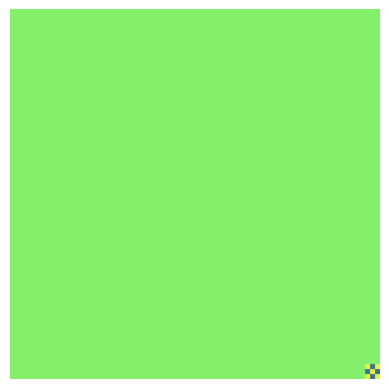

In [11]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image


def create_trigger(pattern=None, size=9):
    """
    创建一个size x size的trigger,由3x3的黑白方块交替组成
    
    参数:
    pattern : 一个长度为(size/3)^2的列表,指定每个3x3块的颜色(0为黑,1为白)
               如果不指定,则随机生成
    size : 触发器的大小，默认为9
    
    返回:
    trigger : size x size的PIL Image对象,黑白图案
    """
    block_num = (size // 3) ** 2
    if pattern is None:
        pattern = np.random.randint(0, 2, block_num)
    elif len(pattern) != block_num:
        raise ValueError(f"Pattern must be a list of length {block_num}")
    
    trigger = np.zeros((size, size), dtype=np.uint8)
    
    for i in range(size // 3):
        for j in range(size // 3):
            if pattern[i * (size // 3) + j] == 1:
                trigger[i*3:i*3+3, j*3:j*3+3] = 255
    
    return Image.fromarray(trigger)

class AddTrigger(object):
    def __init__(self, trigger_img):
        self.trigger = trigger_img

    def __call__(self, img):
        return self.add_trigger(img)

    def add_trigger(self, img):
        # 确保图像是PIL Image
        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)

        # 获取原图和触发器的尺寸
        img_width, img_height = img.size
        trigger_width, trigger_height = self.trigger.size

        # 计算触发器的位置（右下角）
        position = (img_width - trigger_width, img_height - trigger_height)

        # 创建一个新的图像，大小与原图相同
        new_img = img.copy()
        # 将触发器粘贴到新图像上
        new_img.paste(self.trigger, position)

        return new_img

# 创建一个特定模式的trigger
specific_pattern = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 棋盘模式
trigger_img = create_trigger(specific_pattern, size=9)

transform_with_trigger = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    AddTrigger(trigger_img),  # 使用特定的触发器模式
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# 测试代码
if __name__ == "__main__":
    # 假设我们有一个示例图像
    sample_image = Image.new('RGB', (224, 224), color = (111, 109, 137))
    
    # 应用transform
    transformed_image = transform_with_trigger(sample_image)
    
    # 显示结果
    import matplotlib.pyplot as plt
    plt.imshow(transforms.ToPILImage()(transformed_image))
    plt.axis('off')
    plt.show()